<a href="https://colab.research.google.com/github/thomaslu678/gee-test/blob/main/clean/10_basic_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: Requires export_clean.csv (cleaned up export CSV with sorts and time columns)

In [69]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point
import requests

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import shap

import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Year 2/Fall 2025/HONOR 3700/Data/2/dataset_airport.csv')

In [5]:
df.columns

Index(['initial', 'final', 'delta_time', 'delta_NDVI', 'delta_NDBI',
       'delta_NDMI', 'delta_Albedo', 'delta_LST_diff'],
      dtype='object')

In [7]:
train_columns = ['delta_time', 'delta_NDVI', 'delta_NDBI',
       'delta_NDMI', 'delta_Albedo', 'delta_LST_diff']
train_df = df[train_columns]

In [8]:
train_df

,delta_time,delta_NDVI,delta_NDBI,delta_NDMI,delta_Albedo,delta_LST_diff
0,-220491592.0,0.030604,-0.060631,0.060631,-0.028791,5.766200
1,-87781192.0,-0.018957,0.017367,-0.017367,-0.009589,3.500052
2,-58751249.0,0.009447,0.020237,-0.020237,-0.019705,-0.475105
3,692079.0,0.028090,0.035513,-0.035513,-0.022004,-0.406744
4,64282318.0,-0.015205,0.006155,-0.006155,-0.019146,0.102541
...,...,...,...,...,...,...
17389,31795218.0,-0.043102,0.067103,-0.067103,0.009865,1.811551
17390,33177616.0,-0.014465,0.090868,-0.090868,0.001137,0.591317
17391,1382405.0,-0.084654,-0.040490,0.040490,0.020492,1.500511
17392,2764803.0,-0.056017,-0.016724,0.016724,0.011764,0.280278


In [14]:
train_df['delta_LST_diff'].mean()

np.float64(-1.8196373987271504)

In [ ]:
train_df['delta_LST_diff'].std()

<Axes: >

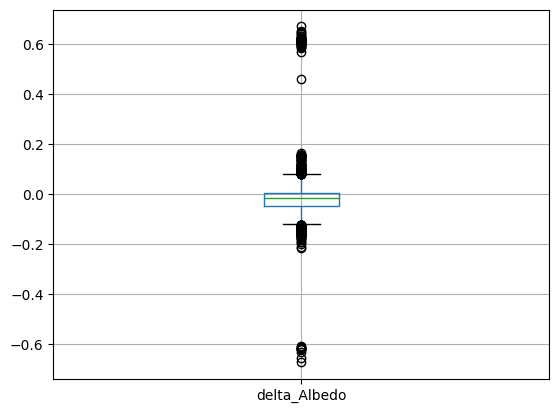

In [9]:
train_df.boxplot(column=['delta_Albedo'])

# Prep ML

In [17]:
TARGET = 'delta_LST_diff'
FEATURES = [c for c in train_df.columns if c != TARGET]

X = df[FEATURES].values.astype(np.float32)
y = df[TARGET].values.astype(np.float32).reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [65]:
rf = RandomForestRegressor(
    n_estimators=200,      # number of trees
    max_depth=30,        # grow fully (can tune)
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,              # use all CPU cores
)

rf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=30, min_samples_leaf=2, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [162]:
def rf_predict_median(rf, X):
    # shape: (n_trees, n_samples)
    tree_preds = np.array([tree.predict(X) for tree in rf.estimators_])

    # take median across trees
    return np.median(tree_preds, axis=0)

## Train metrics

In [141]:
y_train_pred = rf.predict(X_train)

mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Train MSE: {mse:.4f}")
print(f"Train MAE: {mae:.4f}")
print(f"Train R2: {r2:.4f}")

Train MSE: 3.8336
Train MAE: 1.4008
Train R2: 0.8116


In [142]:
y_train_pred = rf_predict_median(rf, X_train)

mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Train MSE: {mse:.4f}")
print(f"Train MAE: {mae:.4f}")
print(f"Train R2: {r2:.4f}")

Train MSE: 1.6861
Train MAE: 0.8156
Train R2: 0.9171


## Validation metrics

In [156]:
y_val = y_val.flatten()
y_val.shape

(1740,)

In [158]:
y_val_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R2: {r2:.4f}")

Validation MSE: 15.6283
Validation MAE: 2.9765
Validation R2: 0.2609


In [159]:
y_val_pred_median = rf_predict_median(rf, X_val)

mse = mean_squared_error(y_val, y_val_pred_median)
mae = mean_absolute_error(y_val, y_val_pred_median)
r2 = r2_score(y_val, y_val_pred_median)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R2: {r2:.4f}")

Validation MSE: 16.0721
Validation MAE: 3.0018
Validation R2: 0.2399


In [160]:
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)

        Feature  Importance
0    delta_time    0.337244
4  delta_Albedo    0.234116
1    delta_NDVI    0.210481
3    delta_NDMI    0.109205
2    delta_NDBI    0.108954


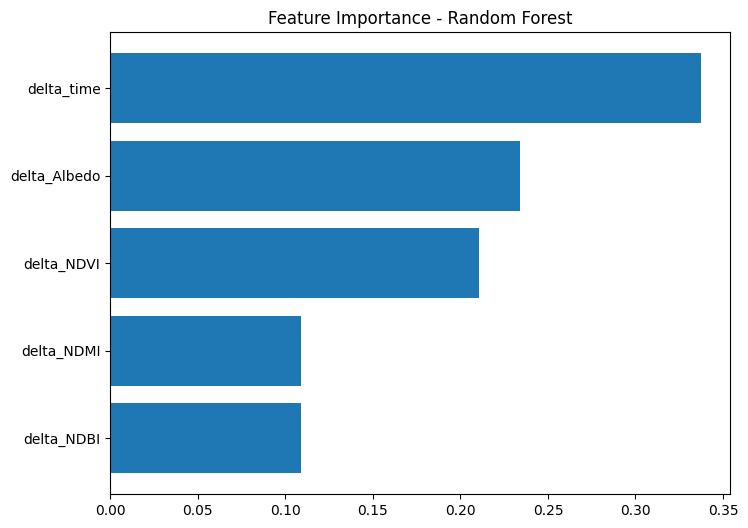

In [161]:
plt.figure(figsize=(8,6))
plt.barh(feature_importance_df["Feature"],
         feature_importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Random Forest")
plt.show()

In [163]:
index = 632
sample = X_train[index].reshape(1, -1)

# Get prediction from each individual tree
tree_predictions = np.array([
    tree.predict(sample)[0] for tree in rf.estimators_
])

print("Mean of tree predictions:", tree_predictions.mean())
print("Median:", np.median(tree_predictions))
print("RF prediction:", rf.predict(sample)[0])
print("True value:", y_train[index])


Mean of tree predictions: -3.746735127631249
Median: -4.428044935067495
RF prediction: -3.746735127631249
True value: [-4.5152044]


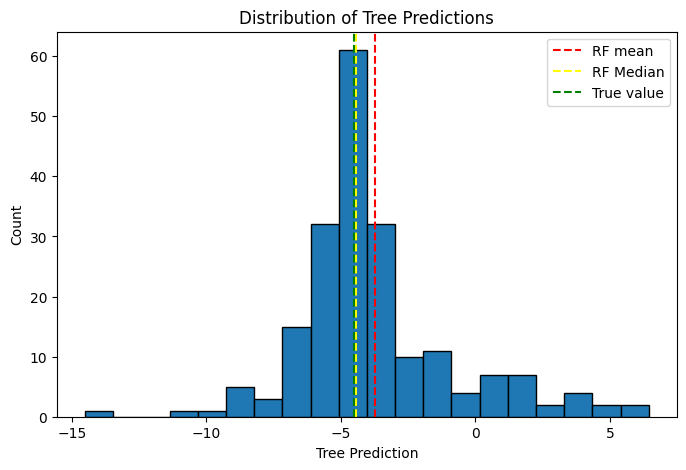

In [164]:
plt.figure(figsize=(8,5))
plt.hist(tree_predictions, bins=20, edgecolor='black')
plt.axvline(tree_predictions.mean(), color='red', linestyle='--', label='RF mean')
plt.axvline(np.median(tree_predictions), color='yellow', linestyle='--', label='RF Median')
plt.axvline(y_train[index], color='green', linestyle='--', label='True value')
plt.xlabel("Tree Prediction")
plt.ylabel("Count")
plt.title("Distribution of Tree Predictions")
plt.legend()
plt.show()

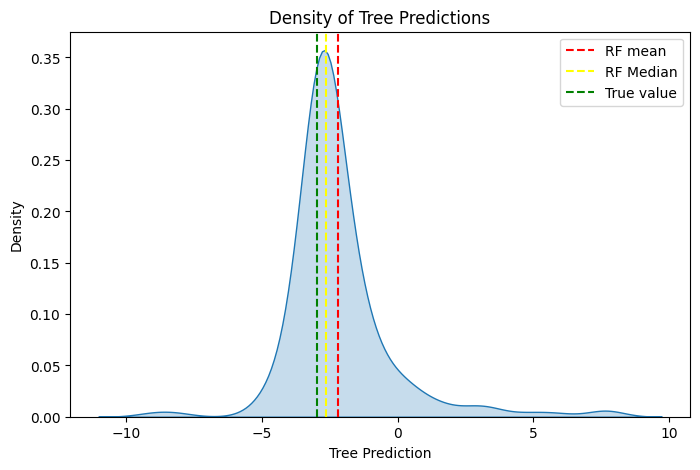

In [119]:
plt.figure(figsize=(8,5))
sns.kdeplot(tree_predictions, fill=True)
plt.axvline(tree_predictions.mean(), color='red', linestyle='--', label='RF mean')
plt.axvline(np.median(tree_predictions), color='yellow', linestyle='--', label='RF Median')
plt.axvline(y_train[index], color='green', linestyle='--', label='True value')
plt.xlabel("Tree Prediction")
plt.title("Density of Tree Predictions")
plt.legend()
plt.show()

# Inverse modeling

In [ ]:
FEATURES

['NDVI',
 'NDBI',
 'NDMI',
 'Albedo',
 'time_years',
 'long',
 'lat',
 'distance',
 'hour_of_day',
 'month']

In [ ]:
feature_names = FEATURES
feature_to_idx = {name: i for i, name in enumerate(feature_names)}

In [ ]:
def inverse_solve(
    model,
    scaler,
    y_target,
    n_solutions=10,
    steps=500,
    lr=0.001,
    tolerance=0.01,
    fixed_features=None,
    l2_reg=0.01,
    bounds=None
):
    """
    model: trained PyTorch model (already on device)
    scaler: fitted StandardScaler
    y_target: desired label (float)
    n_solutions: number of random restarts
    tolerance: keep solutions with |prediction - target| < tolerance
    fixed_features: dict {"NDVI": value, ...}
    bounds: dict {"NDVI": (min,max), ...}
    """

    model.eval()
    solutions = []

    y_target_tensor = torch.tensor([[y_target]], dtype=torch.float32).to(device)

    for _ in range(n_solutions):

        # random initialization in scaled space
        x = torch.randn((1, len(feature_names)), device=device, requires_grad=True)

        optimizer_x = torch.optim.Adam([x], lr=lr)

        for step in range(steps):

            optimizer_x.zero_grad()

            pred = model(x)
            loss = (pred - y_target_tensor).pow(2).mean()

            # L2 regularization (keeps solution near origin in scaled space)
            loss += l2_reg * torch.norm(x)

            # Soft constraint: fixed features
            if fixed_features:
                for fname, fval in fixed_features.items():
                    idx = feature_to_idx[fname]
                    scaled_val = (fval - scaler.mean_[idx]) / scaler.scale_[idx]
                    loss += 100 * (x[0, idx] - scaled_val) ** 2

            loss.backward()
            optimizer_x.step()

            # Hard bounds
            if bounds:
                with torch.no_grad():
                    for fname, (low, high) in bounds.items():
                        idx = feature_to_idx[fname]
                        low_s = (low - scaler.mean_[idx]) / scaler.scale_[idx]
                        high_s = (high - scaler.mean_[idx]) / scaler.scale_[idx]
                        x[0, idx].clamp_(low_s, high_s)

        # Check tolerance
        with torch.no_grad():
            pred = model(x)
            error = torch.abs(pred - y_target_tensor).item()

            if error < tolerance:
                x_np = x.cpu().numpy()
                x_orig = scaler.inverse_transform(x_np)
                solutions.append(x_orig.flatten())

    return np.array(solutions)

In [ ]:
solutions_1 = inverse_solve(
    model=model,
    scaler=scaler,
    y_target=0.1,
    n_solutions=100,
    tolerance=0.1
)

print("Found solutions:", len(solutions_1))

Found solutions: 100


In [ ]:
solutions_2 = inverse_solve(
    model,
    scaler,
    y_target=-0.03,
    n_solutions=100,
    tolerance=0.01,
    fixed_features={"NDVI": 0.3}
)

print("Found solutions:", len(solutions_2))

Found solutions: 0


In [ ]:
bounds = {
    "NDVI": (0, 1),
    "NDMI": (-1, 1),
    "hour_of_day": (0, 23),
    "month": (1, 12)
}

solutions_3 = inverse_solve(
    model,
    scaler,
    y_target=-0.03,
    n_solutions=200,
    tolerance=0.02,
    bounds=bounds
)

In [ ]:
len(solutions_3)

0

In [ ]:
df_solutions = pd.DataFrame(solutions_1, columns=feature_names)
df_solutions.describe()

,NDVI,NDBI,NDMI,Albedo,time_years,long,lat,distance,hour_of_day,month
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.047244,-0.198664,0.322673,0.114781,46.718273,127.018021,37.570206,211.192184,1.067500,3.065200
std,1.048663,0.436466,0.486610,0.049406,7.731159,0.013555,0.001527,171.065903,0.937328,3.210405
min,-0.310570,-0.914157,-0.497046,0.072249,34.533051,126.999107,37.567760,-4.660467,-0.463833,-0.893876
25%,0.548232,-0.197297,0.374165,0.086413,45.765587,127.009590,37.570038,161.795074,1.118930,0.546973
50%,0.983552,-0.117079,0.386100,0.101974,47.689957,127.021118,37.570522,193.870132,1.276219,3.372518
75%,1.529038,-0.029648,0.574648,0.114908,50.086334,127.029091,37.570805,234.583466,1.306105,5.947385
max,2.485967,0.264861,0.775500,0.198364,55.516457,127.031212,37.571896,470.372681,2.100077,6.353000


In [ ]:
df_solutions

,NDVI,NDBI,NDMI,Albedo,time_years,long,lat,distance,hour_of_day,month
0,0.548232,-0.029648,-0.497046,0.101974,47.689957,127.009590,37.567760,-4.660467,1.306105,6.353000
1,1.529038,-0.914157,0.775500,0.086413,34.533051,127.029091,37.570038,470.372681,2.100077,0.546973
2,-0.310570,-0.197297,0.574648,0.198364,50.086334,127.031212,37.570805,161.795074,1.118930,-0.893876
3,0.983552,-0.117079,0.386100,0.114908,45.765587,127.021118,37.570522,234.583466,-0.463833,5.947385
4,2.485967,0.264861,0.374165,0.072249,55.516457,126.999107,37.571896,193.870132,1.276219,3.372518


In [ ]:
single_input = solutions_1[4]

single_input_scaled = scaler.transform(single_input.reshape(1, -1))  # Shape it to 2D for scaler
single_input_tensor = torch.tensor(single_input_scaled, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_label = model(single_input_tensor).cpu().numpy()  # Convert the output to a NumPy array

print(f"Predicted label: {predicted_label}")


Predicted label: [[0.03285752]]


In [ ]:
single_input

array([2.4859669e+00, 2.6486096e-01, 3.7416539e-01, 7.2248593e-02,
       5.5516457e+01, 1.2699911e+02, 3.7571896e+01, 1.9387013e+02,
       1.2762189e+00, 3.3725176e+00], dtype=float32)

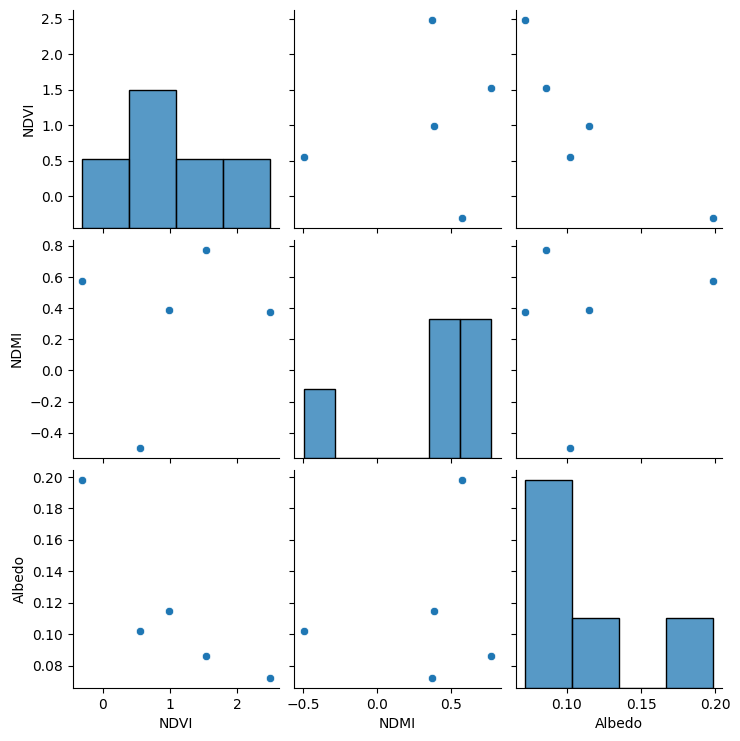

In [ ]:
import seaborn as sns

sns.pairplot(df_solutions[["NDVI","NDMI","Albedo"]])

# Shap Analysis

In [ ]:
# Sample for SHAP (adjust sizes if needed)
BACKGROUND_SIZE = 200
EXPLAIN_SIZE = 500

background_idx = np.random.choice(len(X_train), BACKGROUND_SIZE, replace=False)
explain_idx = np.random.choice(len(X_val), EXPLAIN_SIZE, replace=False)

X_background = torch.from_numpy(X_train[background_idx]).to(device)
X_explain = torch.from_numpy(X_val[explain_idx]).to(device)

In [ ]:
model.eval()

explainer = shap.DeepExplainer(model, X_background)
shap_values = explainer.shap_values(X_explain)

In [ ]:
shap_values.shape

(500, 10, 1)

In [ ]:
shap_values[0]

array([[-1.97117421e-04],
       [ 8.53447727e-06],
       [ 5.29622012e-05],
       [-9.87795414e-04],
       [-1.59431454e-02],
       [ 2.23160442e-03],
       [-2.23814306e-04],
       [-1.79877058e-02],
       [ 2.83390749e-03],
       [-8.51181429e-03]])

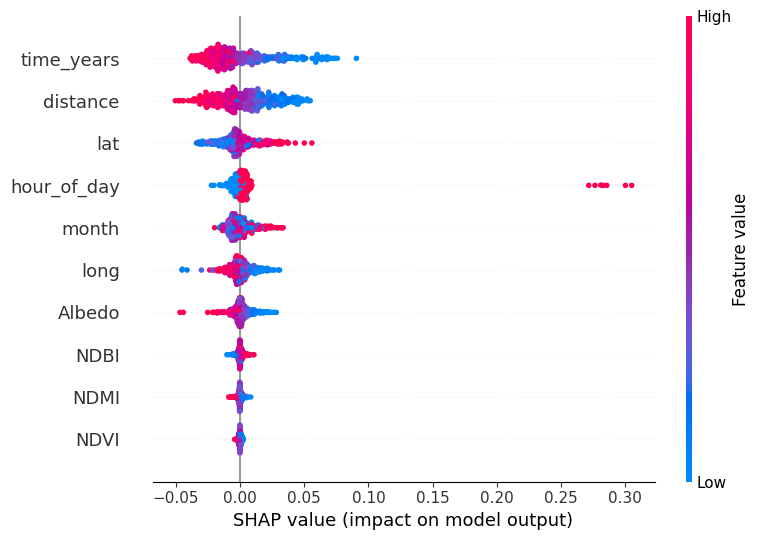

In [ ]:
# Remove the last dimension
shap_vals = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_vals = np.squeeze(shap_vals)  # shape: (5000, 10)

# Now plot
shap.summary_plot(
    shap_vals,
    X_val[explain_idx],
    feature_names=FEATURES,
    show=True
)

In [ ]:
print("SHAP values shape:", shap_vals.shape)  # should be (500, 10)

SHAP values shape: (500, 10)


## Save the model

In [ ]:
PATH = "/content/sample_data/MLP.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
test_input = np.array([0.008107, -0.042450, 0.042450, 0.185196, 18.979367, 317.553292, 1, 12, -0.029627, 3.3725176e+00])

# single_input_scaled = scaler.transform(test_input.reshape(1, -1))  # Shape it to 2D for scaler
single_input_scaled = test_input.reshape(1, -1)  # Shape it to 2D for scaler
# single_input_scaled = scaler.transform(test_input.reshape(1, -1))  # Shape it to 2D for scaler
single_input_tensor = torch.tensor(single_input_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predicted_label = model(single_input_tensor).cpu().numpy()  # Convert the output to a NumPy array

print(f"Predicted label: {predicted_label}")

Predicted label: [[5.6785226]]
